In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pylab as plt
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["figure.figsize"]=(4,4)
import sys
sys.path.insert(0,"../helper_functions")

In [2]:
adata = sc.read_h5ad("/Users/snyquist/Dropbox (Gladstone)/scRNA_HMO_Longitudinal_Analysis/scRNA_seq_data/adata_epithelial_no_doublets_FINAL.h5ad")

In [3]:
Futs = ["FUT1","FUT2","FUT3","FUT4","FUT5","FUT6","FUT7","FUT8","FUT9","FUT10","FUT11"]
st32 = ["ST3GAL1","ST3GAL2","ST3GAL3","ST3GAL4","ST3GAL5","ST3GAL6"]
st6gal = ["ST6GAL1","ST6GAL2"]
gcnt = ["GCNT1","GCNT2","GCNT3","GCNT4"]
b3gnt = ["B3GNT2","B3GNT3","B3GNT4","B3GNT5","B3GNT6","B3GNT7","B3GNT8","B3GNT9"]
b3galt = ["B3GALT1","B3GALT2","B3GALT4","B3GALT5","B3GALT6"]
b4galt = ["B4GALT1","B4GALT2","B4GALT3","B4GALT4","B4GALT5","B4GALT6","B4GALT7","B4GALT8","B4GALT9"]
st6galnac = ["ST6GALNAC1","ST6GALNAC2","ST6GALNAC3","ST6GALNAC4","ST6GALNAC5","ST6GALNAC6"]
b3gat = ["B3GAT1","B3GAT2","B3GAT3","B2GLCT"]
b3galnt = ["B3GALNT1","B3GALNT2"]
b4galnt = ["B4GALNT1","B4GALNT2","B4GALNT3","B4GALNT4"]
genelists = [Futs,st32,st6gal,gcnt,b3gnt,b3galt,b4galt,st6galnac,b3gat,b4galnt,b3galnt]


## Clean and visualize HMO concentration data

HMO data represented in nmol/mL

In [4]:
all_hmo_genes = []
for g in genelists:
    all_hmo_genes = all_hmo_genes + [i for i in g if i in adata.raw.var_names]

In [5]:
HMO=pd.read_csv("../../HMO_nmol_ml.csv")

In [6]:
HMO_names = ['2\'FL', '3FL', 'DFLac', '3\'SL', '6\'SL', 'LNT',
       'LNnT', 'LNFP I', 'LNFP II', 'LNFP III', 'LSTb', 'LSTc', 'DFLNT', 'LNH',
       'DSLNT', 'FLNH', 'DFLNH', 'FDSLNH', 'DSLNH']

In [7]:
for i in HMO_names:
    HMO[i] = HMO[i].astype(float)

In [8]:
# subset to samples where we know the time postpartum
HMO_with_time = HMO.loc[HMO["time_postpartum_weeks"].notna()]

In [9]:
# name a column to get us unique sample names for each donor and timepoint
HMO_with_time["Donor_time"] = HMO_with_time["Donor"]+HMO_with_time["time_postpartum_weeks"].astype(str)

/var/folders/2w/wzpnv4x92_lbnlcccg_sb4t40000gq/T/ipykernel_15547/2916163566.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HMO_with_time["Donor_time"] = HMO_with_time["Donor"]+HMO_with_time["time_postpartum_weeks"].astype(str)


In [10]:
# merge replicates by taking the mean
HMOs_means_by_sample_wtime = HMO_with_time.groupby("Donor_time")[HMO_names].mean()

In [11]:
# adjust index so only one replicate entry
HMO_with_time = HMO_with_time.loc[~HMO_with_time["Donor_time"].duplicated()]

In [12]:
# set index to the new unique names for each sample (with replicates merged)
HMO_with_time.index = HMO_with_time["Donor_time"]
# replace values with the means of replicates (or original value where there was one replicate)
HMO_with_time.loc[HMOs_means_by_sample_wtime.index, HMO_names] = HMOs_means_by_sample_wtime

In [14]:
# remove samples without matched RNA
HMO_sub=HMO.loc[HMO["Sample#"].notna()]
HMO_sub=HMO_sub.loc[HMO_sub["Sample#"]!=" "]

In [21]:
# merge replicates as above
HMOs_means_by_sample = HMO_sub.groupby("Sample#")[HMO_names].mean()

In [22]:
HMO_sub = HMO_sub.loc[~HMO_sub["Sample#"].duplicated()]

In [23]:
HMO_sub.index = HMO_sub["Sample#"]
HMO_sub.loc[HMOs_means_by_sample.index, HMO_names] = HMOs_means_by_sample

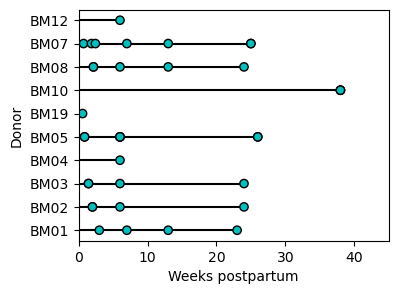

In [19]:
# Visualize samples by donor and timepostpartum for which we have matched RNA
import numpy as np
import math
plt.rcParams["figure.figsize"]=(4,3)
HMO_sub_sec = HMO_sub[HMO_sub["Secretor"]=="1"]
# plot all samples by time
x_vals = [] # weeks postpartum
y_vals = [] # donor index
y_ticklabels = list(HMO_sub_sec["Donor"].unique()) # donor names
colors = [] # blue for with matched sample, red for without
max_timepp = HMO_sub_sec["time_postpartum_weeks"].max()+5
for d,h in HMO_sub_sec.groupby("Donor"):
    donor_ind = y_ticklabels.index(d)
    max_x = 0
    for i in h.index:
        s = h.loc[i,"Sample#"]
        
            
        t = h.loc[i,"time_postpartum_weeks"]
        if not math.isnan(t):
            if type(s)==str:
                colors.append("c")
            else:
                colors.append("r")
            x_vals.append(t)
            if t > max_x:
                max_x = t
        else:
            continue #exclude samples whose time postpartum is unknown
            #x_vals.append(max_timepp)
            #max_x = max_timepp
        
        y_vals.append(donor_ind)
    
    plt.plot([0,max_x],[donor_ind,donor_ind],c="k",zorder=1)
plt.scatter(x_vals,y_vals,c=colors,edgecolors='black')
plt.yticks(range(0,len(y_ticklabels)),y_ticklabels)
xticks,x_labels = plt.xticks()
plt.xlim(0,max_timepp+2)
#plt.xticks(list(xticks)+[max_timepp],list(xticks)+["NA"])
plt.xlabel("Weeks postpartum")
plt.ylabel("Donor")
plt.savefig("../Figures/Figure4 - HMO + time and celltype proportions/Fig3A_samples_included_secretors.pdf",bbox_inches="tight")

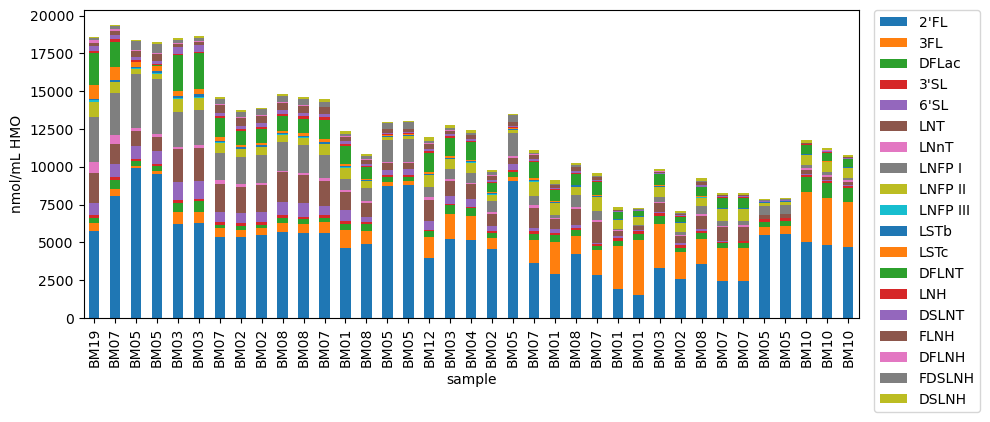

In [20]:
# visualize samples with matched RNA with merged replicates and no nonsecretors
plt.rcParams["figure.figsize"]=(10,4)
HMO_sub_sec = HMO_sub[HMO_sub["Secretor"]=="1"]
ax=HMO_sub_sec.sort_values("time_postpartum_weeks")[HMO_names].plot.bar(stacked=True)
plt.ylabel("nmol/mL HMO")
ax.set_xticklabels(HMO_sub_sec.sort_values("time_postpartum_weeks")["Donor"])
plt.xlabel("sample")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig("../Figures/FigureS3 - HMO + time and celltype proportions/HMO_composition_stacked_bar_with_time_just_samples_with_RNA_duplicates_merged_secretors.pdf",bbox_inches="tight")

## HMO regression with time postpartum

In [26]:
import statsmodels.formula.api as smf


In [27]:
# normalize HMO concentrations
HMO_withtime_normed = HMO_with_time.copy()
for h in HMO_names:
    HMO_withtime_normed[h] = HMO_withtime_normed[h]/HMO_withtime_normed[h].mean()
    #HMO_withtime[h] = np.log(HMO_withtime[h])
    HMO_withtime_normed[h]=(HMO_withtime_normed[h]-HMO_withtime_normed[h].mean())-HMO_withtime_normed[h].std()

In [28]:
# normalize time
h="time_postpartum_weeks"
HMO_withtime_normed[h] = HMO_withtime_normed[h]/HMO_withtime_normed[h].mean()
#HMO_withtime[h] = np.log(HMO_withtime[h])
HMO_withtime_normed[h]=(HMO_withtime_normed[h]-HMO_withtime_normed[h].mean())-HMO_withtime_normed[h].std()

In [29]:
# adjust names so statsmodels will accept them
numbered_names = {"2'FL":"twoFL",
 '3FL':"threeFL",
 "3'SL":"threeSL",
 "6'SL":"sixSL"}

In [32]:
# run  regression removing the non-secretor samples

In [33]:
HMO_withtime_normed["Secretor"].unique()

array(['1', '0'], dtype=object)

In [34]:
HMO_withtime_normed_secretor = HMO_withtime_normed.loc[HMO_withtime_normed["Secretor"]=="1"]

In [35]:
# run regression of HMO concentrations over time with non-secretors removed
time_results_table_sec = pd.DataFrame(index=HMO_names,columns = ["pvalue","Coef","Group Var","conf int"])
for h in HMO_names:
    h_old = h
    if h in numbered_names.keys():
        HMO_withtime_normed_secretor[numbered_names[h]] = HMO_withtime_normed_secretor[h]
        h = numbered_names[h]
    if " " in h:
        HMO_withtime_normed_secretor[h.replace(" ","")] = HMO_withtime_normed_secretor[h]
        h=h.replace(" ","")
    md = smf.mixedlm(h+" ~ time_postpartum_weeks", HMO_withtime_normed_secretor, groups=HMO_withtime_normed_secretor["Donor"])
    mdf = md.fit(method=["lbfgs"])
    time_results_table_sec.loc[h_old,"pvalue"] =  mdf.pvalues["time_postpartum_weeks"]
    time_results_table_sec.loc[h_old,"Group Var"]= mdf.bse_re["Group Var"]
    time_results_table_sec.loc[h_old,"conf int"] = [mdf.conf_int().loc["time_postpartum_weeks"][0],mdf.conf_int().loc["time_postpartum_weeks"][1]]
    time_results_table_sec.loc[h_old,"Coef"] = mdf.fe_params["time_postpartum_weeks"]
    print(mdf.summary())

/var/folders/2w/wzpnv4x92_lbnlcccg_sb4t40000gq/T/ipykernel_3033/3232992020.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HMO_withtime_normed_secretor[numbered_names[h]] = HMO_withtime_normed_secretor[h]
/var/folders/2w/wzpnv4x92_lbnlcccg_sb4t40000gq/T/ipykernel_3033/3232992020.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HMO_withtime_normed_secretor[numbered_names[h]] = HMO_withtime_normed_secretor[h]
/var/folders/2w/wzpnv4x92_lbnlcccg_sb4t40000gq/T/ipykernel_3033/3232992020.py:6: SettingWithCo

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    twoFL   
No. Observations:     37         Method:                REML    
No. Groups:           11         Scale:                 0.0482  
Min. group size:      1          Log-Likelihood:        -11.0795
Max. group size:      6          Converged:             Yes     
Mean group size:      3.4                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept             -0.816    0.129 -6.300 0.000 -1.070 -0.562
time_postpartum_weeks -0.371    0.050 -7.478 0.000 -0.469 -0.274
Group Var              0.138    0.410                           

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    threeFL 
No. Observations:     37         Method:            

/var/folders/2w/wzpnv4x92_lbnlcccg_sb4t40000gq/T/ipykernel_3033/3232992020.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HMO_withtime_normed_secretor[h.replace(" ","")] = HMO_withtime_normed_secretor[h]
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of

                              Mixed Linear Model Regression Results
Model:                           MixedLM                Dependent Variable:                LNFPIII
No. Observations:                37                     Method:                            REML   
No. Groups:                      11                     Scale:                             0.3395 
Min. group size:                 1                      Log-Likelihood:                    inf    
Max. group size:                 6                      Converged:                         Yes    
Mean group size:                 3.4                                                              
--------------------------------------------------------------------------------------------------
                      Coef.            Std.Err.            z    P>|z|     [0.025         0.975]   
--------------------------------------------------------------------------------------------------
Intercept              0.000             

             Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     DSLNH 
No. Observations:     37          Method:                 REML  
No. Groups:           11          Scale:                  0.0572
Min. group size:      1           Log-Likelihood:         inf   
Max. group size:      6           Converged:              Yes   
Mean group size:      3.4                                       
----------------------------------------------------------------
                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept              0.000                                    
time_postpartum_weeks -0.011    0.054 -0.207 0.836 -0.117  0.095
Group Var              0.000                                    



/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2478: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.scale

In [38]:
import statsmodels.stats.multitest
time_results_table_sec["padj"]=statsmodels.stats.multitest.multipletests(time_results_table_sec["pvalue"], alpha=0.05, method='fdr_bh')[1]

/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/multitest.py:350: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/multitest.py:356: RuntimeWarning: invalid value encountered in accumulate
  pvals_corrected = np.minimum.accumulate(pvals_corrected_raw[::-1])[::-1]
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/multitest.py:358: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/multitest.py:268: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1


In [40]:
# when non-secretors are removed, 3SL significantly decreases with time

In [82]:
time_results_table_sec.to_csv("/Users/snyquist/Dropbox (Gladstone)/HMO_scRNAseq_manuscript/Supplemental Tables/Table S3 - time_HMO_LMM_results.csv")

In [41]:
sig_HMOs = time_results_table_sec.loc[time_results_table_sec["padj"] <= 0.05].index

In [42]:
HMO_withtime_normed_secretor["time_postpartum_weeks_unnormed"] = HMO_with_time.loc[HMO_withtime_normed_secretor.index, "time_postpartum_weeks"]

/var/folders/2w/wzpnv4x92_lbnlcccg_sb4t40000gq/T/ipykernel_3033/2576035096.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HMO_withtime_normed_secretor["time_postpartum_weeks_unnormed"] = HMO_with_time.loc[HMO_withtime_normed_secretor.index, "time_postpartum_weeks"]


In [43]:
HMO_colors_and_lines = {'2\'FL':{"color":"#e6194B","linestyle":"solid"}, 
 '3FL':{"color":"#469990","linestyle":"solid"}, 
 '3\'SL':{"color":"#4363d8","linestyle":"solid"}, 
 '6\'SL':{"color":"#911eb4","linestyle":"solid"}, 
 'LNT':{"color":"#f58231","linestyle":"solid"},
 'LNH':{"color":"#bfef45","linestyle":"solid"}, 
 'LNnT':{"color":"#911eb4","linestyle":"dotted"}, 
 'LNFP I':{"color":"#e6194B","linestyle":"dotted"}, 
 'LNFP III':{"color":"#469990","linestyle":"dotted"},
 'LSTb':{"color":"#4363d8","linestyle":"dotted"}, 
 'LSTc':{"color":"#bfef45","linestyle":"dotted"}, 
 'DFLNH':{"color":"#f58231","linestyle":"dotted"}, 
 'DSLNT':{"color":"#e6194B","linestyle":"dashed"}, 
 'FLNH':{"color":"#911eb4","linestyle":"dashed"}, 
 'DFLNT':{"color":"#4363d8","linestyle":"dashed"} , 
 'FDSLNH':{"color":"#469990","linestyle":"dashed"},
 "DFLac":{"color":"#f58231","linestyle":"dashed"},
 "LNFP II":{"color":"#bfef45","linestyle":"dashed"}}

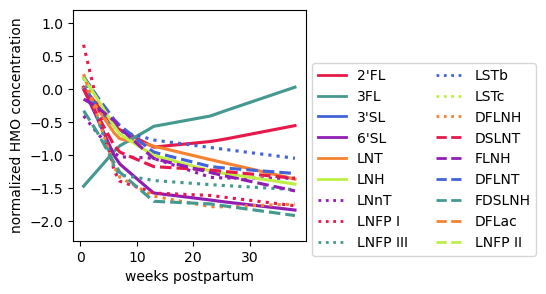

In [45]:
from matplotlib.lines import Line2D
import seaborn as sns
plt.rcParams["figure.figsize"]=(3,3)
for s in sig_HMOs:
    sns.regplot(data=HMO_withtime_normed_secretor,x="time_postpartum_weeks_unnormed",y=s,lowess=True,marker="",ci=None,line_kws=HMO_colors_and_lines[s])
    
plt.ylim((-2.3,1.2))
plt.ylabel("normalized HMO concentration")
plt.xlabel("weeks postpartum")
ax=plt.gca()
custom_lines = [Line2D([0],[0],color=i["color"],linestyle=i["linestyle"],lw=2)for i in HMO_colors_and_lines.values()]
ax.legend(custom_lines,list(HMO_colors_and_lines.keys()),bbox_to_anchor=(1, .3, 0, 0.5),ncols=2)
plt.savefig("../Figures/Figure3 - Coexpression of HMO genes/Fig3B_sig_HMOs_withtime.pdf",bbox_inches="tight")

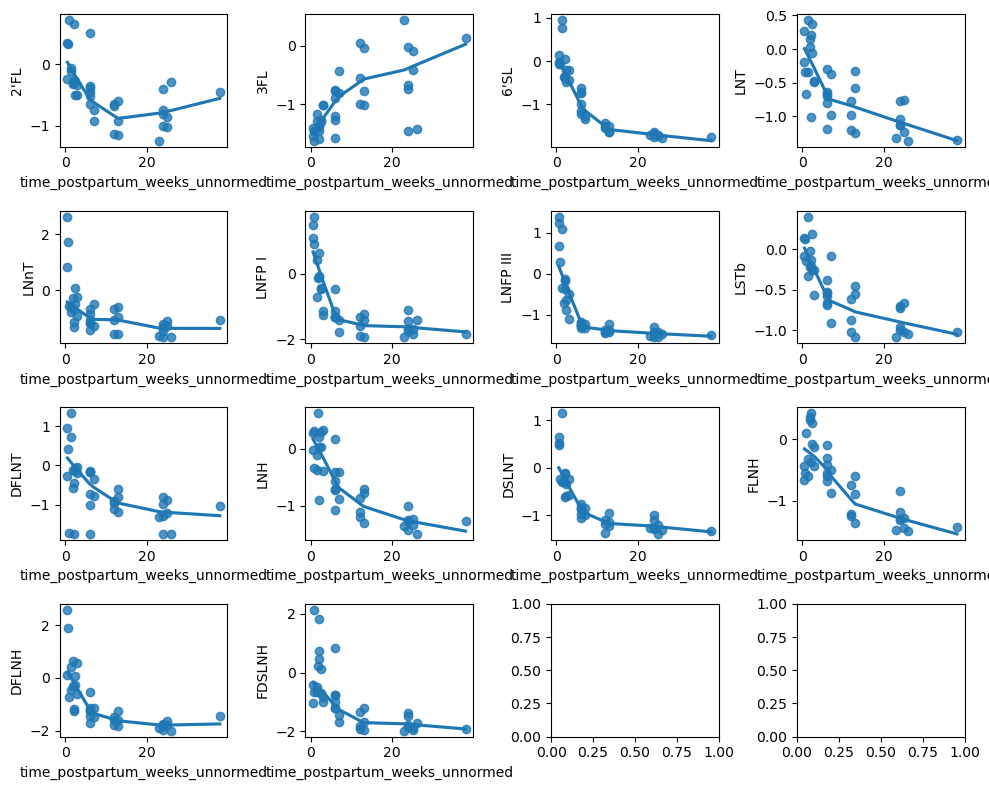

In [46]:
# next make this plot separately for each HMO for supplement
plt.rcParams["figure.figsize"]=(10,8)
p,ax = plt.subplots(4,4)

axs = ax.flatten()
for i,s in enumerate(sig_HMOs):
    sns.regplot(data=HMO_withtime_normed_secretor,x="time_postpartum_weeks_unnormed",y=s,lowess=True,ax=axs[i])
plt.tight_layout()
plt.savefig("../Figures/FigureS3 - HMO + time and celltype proportions/supp_sig_HMOs_withtime_split.pdf",bbox_inches="tight")

## HMO concentration regression with celltype proportions

In [56]:
total_celltype_counts = pd.read_csv("../../sample_celltype_counts.csv",index_col=0)
total_props = total_celltype_counts.divide(total_celltype_counts.sum(axis=1),axis=0)
overlap_samples = list(set(HMO_sub.index).intersection(set(total_props.index)))

In [57]:
HMO_sub_normed = HMO_withtime_normed_secretor.loc[HMO_withtime_normed_secretor["Sample#"].notna()]
HMO_sub_normed = HMO_sub_normed.loc[HMO_sub_normed["Sample#"]!=" "]
HMO_sub_normed.index = HMO_sub_normed["Sample#"]
overlap_samples = list(set(HMO_sub_normed.index).intersection(set(total_props.index)))

In [58]:
combined_time_results_table = pd.DataFrame(columns = ["pvalue","Coef","Group Var","conf int","celltype"])

In [59]:
time_results_table = pd.DataFrame(index=HMO_names,columns = ["pvalue","Coef","Group Var","conf int"])
tmp_overlap_samples = total_props.loc[overlap_samples,"luminal 2"][total_props.loc[overlap_samples,"luminal 2"].notna()].index
ct = "LC1"
HMO_sub_normed.loc[tmp_overlap_samples,ct] = total_props.loc[tmp_overlap_samples, "luminal 2"]
HMO_sub2 = HMO_sub_normed.loc[tmp_overlap_samples]
for h in HMO_names:
    h_old = h
    if h in numbered_names.keys():
        HMO_sub2[numbered_names[h]] = HMO_sub2[h]
        h = numbered_names[h]
    if " " in h:
        HMO_sub2[h.replace(" ","")] = HMO_sub2[h]
        h=h.replace(" ","")
    md = smf.mixedlm(h+" ~ time_postpartum_weeks+ "+ct, HMO_sub2, groups=HMO_sub2["Donor"])
    mdf = md.fit(method=["lbfgs"])
    time_results_table.loc[h_old,"pvalue"] =  mdf.pvalues[ct]
    time_results_table.loc[h_old,"Group Var"]= mdf.bse_re["Group Var"]
    time_results_table.loc[h_old,"conf int"] = [mdf.conf_int().loc[ct][0],mdf.conf_int().loc[ct][1]]
    time_results_table.loc[h_old,"Coef"] = mdf.fe_params[ct]
    #print(mdf.summary())
    
print(time_results_table)
print(time_results_table.loc[time_results_table["pvalue"]<0.05])
time_results_table["celltype"] = ct
time_results_table["padj"]=statsmodels.stats.multitest.multipletests(time_results_table["pvalue"], alpha=0.05, method='fdr_bh')[1]
combined_time_results_table = pd.concat([combined_time_results_table,time_results_table])

/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2478: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.scale * np.diag(self.cov_params())[p:])
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_war

            pvalue      Coef                  Group Var  \
2'FL      0.912919 -0.059696                   0.590672   
3FL       0.054761 -0.792818                   0.337606   
DFLac     0.908717 -0.074484                   1.062678   
3'SL      0.355382   0.43969                        NaN   
6'SL      0.798456  0.244264                        NaN   
LNT       0.676368 -0.268529  21644018688787228917760.0   
LNnT      0.921589  -0.13769                    1.29801   
LNFP I    0.621859 -0.678686                        NaN   
LNFP II     0.2681  0.390624                   0.375966   
LNFP III  0.987764  -0.02087  22934019916789083799552.0   
LSTb       0.88079 -0.068277                        NaN   
LSTc      0.681698  0.863044  35994708114343242760192.0   
DFLNT     0.386133  0.751256                   1.104301   
LNH       0.215215 -0.836448                   0.300711   
DSLNT     0.217242 -0.789677                        NaN   
FLNH      0.216452 -0.787673  14569672984005833654272.0 

/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2478: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.scale * np.diag(self.cov_params())[p:])
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: Th

In [60]:
time_results_table = pd.DataFrame(index=HMO_names,columns = ["pvalue","Coef","Group Var","conf int"])
tmp_overlap_samples = total_props.loc[overlap_samples,'luminal/lactocyte'][total_props.loc[overlap_samples,'luminal/lactocyte'].notna()].index
ct = "LC2"
HMO_sub_normed.loc[tmp_overlap_samples,ct] = total_props.loc[tmp_overlap_samples, 'luminal/lactocyte']
HMO_sub2 = HMO_sub_normed.loc[tmp_overlap_samples]
for h in HMO_names:
    h_old = h
    if h in numbered_names.keys():
        HMO_sub2[numbered_names[h]] = HMO_sub2[h]
        h = numbered_names[h]
    if " " in h:
        HMO_sub2[h.replace(" ","")] = HMO_sub2[h]
        h=h.replace(" ","")
    md = smf.mixedlm(h+" ~ time_postpartum_weeks+ "+ct, HMO_sub2, groups=HMO_sub2["Donor"])
    mdf = md.fit(method=["lbfgs"])
    time_results_table.loc[h_old,"pvalue"] =  mdf.pvalues[ct]
    time_results_table.loc[h_old,"Group Var"]= mdf.bse_re["Group Var"]
    time_results_table.loc[h_old,"conf int"] = [mdf.conf_int().loc[ct][0],mdf.conf_int().loc[ct][1]]
    time_results_table.loc[h_old,"Coef"] = mdf.fe_params[ct]
    #print(mdf.summary())
    
print(time_results_table)
print(time_results_table.loc[time_results_table["pvalue"]<0.05])
time_results_table["celltype"] = ct
time_results_table["padj"]=statsmodels.stats.multitest.multipletests(time_results_table["pvalue"], alpha=0.05, method='fdr_bh')[1]
combined_time_results_table = pd.concat([combined_time_results_table,time_results_table])

/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is n

            pvalue      Coef                  Group Var  \
2'FL      0.408411 -0.199163                   0.559606   
3FL       0.467464  0.164836                   0.300109   
DFLac     0.016294 -0.492794                    1.69093   
3'SL      0.357575  -0.22082                        NaN   
6'SL      0.153866  0.583205                        NaN   
LNT       0.000387  0.803286                   0.229645   
LNnT      0.358745    -0.522                    1.46551   
LNFP I     0.48529  0.425461  52848026387980855803904.0   
LNFP II   0.532589  0.129993                   0.335538   
LNFP III  0.584515  0.329298                        NaN   
LSTb      0.250468  0.222239                   0.164291   
LSTc       0.25759 -1.036425                        NaN   
DFLNT     0.222856   0.59368                   0.797997   
LNH       0.046942  0.499834                    0.33234   
DSLNT     0.438004  0.336736                        NaN   
FLNH      0.116926  0.494072                   0.369433 

/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is n

In [61]:
import statsmodels.api as sm
time_results_table = pd.DataFrame(index=HMO_names,columns = ["pvalue","Coef","Group Var","conf int"])
tmp_overlap_samples = total_props.loc[overlap_samples,'macrophages'][total_props.loc[overlap_samples,'macrophages'].notna()].index
ct = 'macrophages'
HMO_sub_normed.loc[tmp_overlap_samples,ct] = total_props.loc[tmp_overlap_samples, 'macrophages']
HMO_sub2 = HMO_sub_normed.loc[tmp_overlap_samples]
for h in HMO_names:
    h_old = h
    if h in numbered_names.keys():
        HMO_sub2[numbered_names[h]] = HMO_sub2[h]
        h = numbered_names[h]
    if " " in h:
        HMO_sub2[h.replace(" ","")] = HMO_sub2[h]
        h=h.replace(" ","")
    md = smf.mixedlm(h+" ~ time_postpartum_weeks+ "+ct, HMO_sub2, groups=HMO_sub2["Donor"])
    mdf = md.fit(method=["lbfgs"])
    
    time_results_table.loc[h_old,"pvalue"] =  mdf.pvalues[ct]
    time_results_table.loc[h_old,"Group Var"]= mdf.bse_re["Group Var"]
    time_results_table.loc[h_old,"conf int"] = [mdf.conf_int().loc[ct][0],mdf.conf_int().loc[ct][1]]
    time_results_table.loc[h_old,"Coef"] = mdf.fe_params[ct]
    #print(mdf.summary())
    
print(time_results_table)
print(time_results_table.loc[time_results_table["pvalue"]<0.05])
time_results_table["celltype"] = ct
time_results_table["padj"]=statsmodels.stats.multitest.multipletests(time_results_table["pvalue"], alpha=0.05, method='fdr_bh')[1]
combined_time_results_table = pd.concat([combined_time_results_table,time_results_table])

/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2478: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.scale

            pvalue      Coef                   Group Var  \
2'FL      0.496521  0.241565                         NaN   
3FL       0.696706 -0.161845                     0.32031   
DFLac     0.041369  0.829101                     1.48041   
3'SL      0.228044  0.511447                         NaN   
6'SL      0.520282 -0.503219  108585014003576820727808.0   
LNT       0.007983 -1.239759                         NaN   
LNnT      0.152536  1.429989                    1.640612   
LNFP I    0.006311  1.991748                         NaN   
LNFP II   0.299813 -0.347907                    0.281348   
LNFP III  0.636437  0.544716                         NaN   
LSTb      0.783473 -0.105265                         NaN   
LSTc      0.064814  3.097268                         NaN   
DFLNT     0.126011  -1.14483                    0.787309   
LNH       0.265124 -0.486144                    0.384819   
DSLNT     0.972076 -0.029098                         NaN   
FLNH      0.037053 -1.008208            

/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2478: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.scale

In [64]:
import matplotlib.lines
def plot_coefficients_and_int(time_results_table,ct,filter_p=True, sort_by_coef = True):
    if filter_p:
        hmo_res = time_results_table.loc[time_results_table["pvalue"]<0.05]
    else:
        hmo_res = time_results_table
        
    if sort_by_coef:
        hmo_res = hmo_res.sort_values("Coef")
        
    ax=plt.scatter(list(range(hmo_res.shape[0])),hmo_res["Coef"],c="b")
    
    pvalue_asterisks = []
    max_y = 0
    for i,hmo in enumerate(hmo_res.index):
        if type(hmo_res.loc[hmo,"conf int"])==list: # check that this value is not na but that doesnt work on lists so check that it is a list (otherwise it is na, i promise)
            plt.plot([i,i], hmo_res.loc[hmo,"conf int"],c="b")
        
            # update max y value for plotting pvalue markers
            if max(hmo_res.loc[hmo,"conf int"]) > max_y:
                max_y = max(hmo_res.loc[hmo,"conf int"])
            
        if hmo_res.loc[hmo, "padj"] <= 0.001:
            pvalue_asterisks.append("***")    
        elif hmo_res.loc[hmo, "padj"] <= 0.01:
            pvalue_asterisks.append("**")
        elif hmo_res.loc[hmo, "padj"] <= 0.05:
            pvalue_asterisks.append("*")
        else:
            pvalue_asterisks.append("")
            
    
    # plot pvalue index
    for idx, pval in enumerate(pvalue_asterisks):
        plt.text(x=idx, y=max_y, s=pval,horizontalalignment='center')

    plt.xticks(list(range(hmo_res.shape[0])),hmo_res.index,rotation='vertical')
    plt.ylabel(ct+" coefficient")

In [65]:
time_results_table = pd.DataFrame(index=HMO_names,columns = ["pvalue","Coef","Group Var","conf int"])
tmp_overlap_samples = total_props.loc[overlap_samples,'dendritic cells'][total_props.loc[overlap_samples,'dendritic cells'].notna()].index
ct = 'dendriticcells'
HMO_sub_normed.loc[tmp_overlap_samples,ct] = total_props.loc[tmp_overlap_samples, 'dendritic cells']
HMO_sub2 = HMO_sub_normed.loc[tmp_overlap_samples]
for h in HMO_names:
    h_old = h
    if h in numbered_names.keys():
        HMO_sub2[numbered_names[h]] = HMO_sub2[h]
        h = numbered_names[h]
    if " " in h:
        HMO_sub2[h.replace(" ","")] = HMO_sub2[h]
        h=h.replace(" ","")
    md = smf.mixedlm(h+" ~ time_postpartum_weeks+ "+ct, HMO_sub2, groups=HMO_sub2["Donor"])
    mdf = md.fit(method=["lbfgs"])
    time_results_table.loc[h_old,"pvalue"] =  mdf.pvalues[ct]
    time_results_table.loc[h_old,"Group Var"]= mdf.bse_re["Group Var"]
    time_results_table.loc[h_old,"conf int"] = [mdf.conf_int().loc[ct][0],mdf.conf_int().loc[ct][1]]
    time_results_table.loc[h_old,"Coef"] = mdf.fe_params[ct]
    #print(mdf.summary())
    
print(time_results_table)
print(time_results_table.loc[time_results_table["pvalue"]<0.05])
time_results_table["celltype"] = ct
time_results_table["padj"]=statsmodels.stats.multitest.multipletests(time_results_table["pvalue"], alpha=0.05, method='fdr_bh')[1]
combined_time_results_table = pd.concat([combined_time_results_table,time_results_table])

/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/User

            pvalue       Coef                   Group Var  \
2'FL      0.701524  -1.407202                    0.611965   
3FL       0.729055  -0.987026                     0.32794   
DFLac     0.805041   1.053415                    0.986809   
3'SL      0.235657  -3.366186   38093927442975027101696.0   
6'SL      0.009748 -11.845096   26053812458452215136256.0   
LNT       0.004643  -9.674554                    0.290315   
LNnT      0.373552  -8.281621                    1.299726   
LNFP I    0.026935 -18.724235                    1.034224   
LNFP II   0.199034  -2.719729                    0.365558   
LNFP III   0.00387  -17.21288                         NaN   
LSTb      0.000496  -6.148933                    0.377234   
LSTc      0.221421 -15.593294   47684064936406986784768.0   
DFLNT     0.342473  -3.579112                    1.194212   
LNH       0.010143  -9.174402                    0.607982   
DSLNT     0.005757 -10.916923  110172490695941201854464.0   
FLNH      0.006847  -9.2

/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2478: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.scale

In [68]:
time_results_table = pd.DataFrame(index=HMO_names,columns = ["pvalue","Coef","Group Var","conf int"])
tmp_overlap_samples = total_props.loc[overlap_samples,'T cells'][total_props.loc[overlap_samples,'T cells'].notna()].index
ct = 'Tcells'
HMO_sub_normed.loc[tmp_overlap_samples,ct] = total_props.loc[tmp_overlap_samples, 'T cells']
HMO_sub2 = HMO_sub_normed.loc[tmp_overlap_samples]
for h in HMO_names:
    h_old = h
    if h in numbered_names.keys():
        HMO_sub2[numbered_names[h]] = HMO_sub2[h]
        h = numbered_names[h]
    if " " in h:
        HMO_sub2[h.replace(" ","")] = HMO_sub2[h]
        h=h.replace(" ","")
    md = smf.mixedlm(h+" ~ time_postpartum_weeks+ "+ct, HMO_sub2, groups=HMO_sub2["Donor"])
    mdf = md.fit(method=["lbfgs"])
    time_results_table.loc[h_old,"pvalue"] =  mdf.pvalues[ct]
    time_results_table.loc[h_old,"Group Var"]= mdf.bse_re["Group Var"]
    time_results_table.loc[h_old,"conf int"] = [mdf.conf_int().loc[ct][0],mdf.conf_int().loc[ct][1]]
    time_results_table.loc[h_old,"Coef"] = mdf.fe_params[ct]
    #print(mdf.summary())
    
print(time_results_table)
print(time_results_table.loc[time_results_table["pvalue"]<0.05])
time_results_table["celltype"] = ct
time_results_table["padj"]=statsmodels.stats.multitest.multipletests(time_results_table["pvalue"], alpha=0.05, method='fdr_bh')[1]
combined_time_results_table = pd.concat([combined_time_results_table,time_results_table])

/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2478: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.scale

            pvalue       Coef                   Group Var  \
2'FL      0.877176   0.433713                    0.642069   
3FL       0.982753   0.040124                    0.468213   
DFLac     0.046614   4.937608                    1.361271   
3'SL       0.91055   0.297857                         NaN   
6'SL      0.116303  -6.488257                    0.234072   
LNT       0.010359   -7.75389                     0.59818   
LNnT      0.308682   6.887766                    1.602385   
LNFP I    0.295802  -5.706705   97316983954552936988672.0   
LNFP II   0.701617  -0.592937                    0.493563   
LNFP III  0.464061  -4.493621                         NaN   
LSTb      0.315876  -2.468257                    0.290051   
LSTc      0.380923   8.714923  301588985140331319132160.0   
DFLNT      0.75825  -1.363487                    0.933682   
LNH       0.264027  -3.559038                    0.617442   
DSLNT      0.43702   -3.73938                         NaN   
FLNH      0.065159  -6.3

/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2478: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.scale * np.diag(self.cov_params())[p:])
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2055: UserWarning: Th

In [73]:
time_results_table = pd.DataFrame(index=HMO_names,columns = ["pvalue","Coef","Group Var","conf int"])
tmp_overlap_samples = total_props.loc[overlap_samples,'B cells'][total_props.loc[overlap_samples,'B cells'].notna()].index
ct = 'Bcells'
HMO_sub_normed.loc[tmp_overlap_samples,ct] = total_props.loc[tmp_overlap_samples, 'B cells']
HMO_sub2 = HMO_sub_normed.loc[tmp_overlap_samples]
for h in HMO_names:
    h_old = h
    if h in numbered_names.keys():
        HMO_sub2[numbered_names[h]] = HMO_sub2[h]
        h = numbered_names[h]
    if " " in h:
        HMO_sub2[h.replace(" ","")] = HMO_sub2[h]
        h=h.replace(" ","")
    try:
        md = smf.mixedlm(h+" ~ time_postpartum_weeks+ "+ct, HMO_sub2, groups=HMO_sub2["Donor"])
        mdf = md.fit(method=["lbfgs"])
        time_results_table.loc[h_old,"pvalue"] =  mdf.pvalues[ct]
        time_results_table.loc[h_old,"Group Var"]= mdf.bse_re["Group Var"]
        time_results_table.loc[h_old,"conf int"] = [mdf.conf_int().loc[ct][0],mdf.conf_int().loc[ct][1]]
        time_results_table.loc[h_old,"Coef"] = mdf.fe_params[ct]
        #print(mdf.summary())
    except:
        continue
print(time_results_table)
print(time_results_table.loc[time_results_table["pvalue"]<0.05])
time_results_table["celltype"] = ct
time_results_table["padj"]=statsmodels.stats.multitest.multipletests(time_results_table["pvalue"], alpha=0.05, method='fdr_bh')[1]
combined_time_results_table = pd.concat([combined_time_results_table,time_results_table])

/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


            pvalue        Coef    Group Var  \
2'FL           0.0   22.015351   177.164748   
3FL        0.15671  -26.347709     1.488306   
DFLac     0.633484    9.423561     1.195543   
3'SL      0.676069   10.547029     0.557051   
6'SL           NaN         NaN          NaN   
LNT       0.463611  -53.248297     8.570291   
LNnT           0.0 -127.077922  2216.349544   
LNFP I    0.002032  -30.661499  1365.591386   
LNFP II        0.0   -70.20953    309.22098   
LNFP III  0.435845     8.75791  1474.132595   
LSTb           0.0  -47.419129   342.269516   
LSTc      0.109445   30.252428  3509.591439   
DFLNT     0.081822  -13.643807   855.385042   
LNH        0.77136   -20.18295    83.618585   
DSLNT     0.000465    27.40877   972.295566   
FLNH      0.112159   36.923464     1.228759   
DFLNH      0.08354   27.613398  2506.583405   
FDSLNH         NaN         NaN          NaN   
DSLNH      0.95572    2.784982     5.516584   

                                            conf int  
2'FL

/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/multitest.py:356: RuntimeWarning: invalid value encountered in accumulate
  pvals_corrected = np.minimum.accumulate(pvals_corrected_raw[::-1])[::-1]


In [79]:
time_results_table = pd.DataFrame(index=HMO_names,columns = ["pvalue","Coef","Group Var","conf int"])
tmp_overlap_samples = total_props.loc[overlap_samples,'neutrophils'][total_props.loc[overlap_samples,'neutrophils'].notna()].index
ct = 'neutrophils'
HMO_sub_normed.loc[tmp_overlap_samples,ct] = total_props.loc[tmp_overlap_samples, 'neutrophils']
HMO_sub2 = HMO_sub_normed.loc[tmp_overlap_samples]
for h in HMO_names:
    h_old = h
    if h in numbered_names.keys():
        HMO_sub2[numbered_names[h]] = HMO_sub2[h]
        h = numbered_names[h]
    if " " in h:
        HMO_sub2[h.replace(" ","")] = HMO_sub2[h]
        h=h.replace(" ","")
    try:
        md = smf.mixedlm(h+" ~ time_postpartum_weeks+ "+ct, HMO_sub2, groups=HMO_sub2["Donor"])
        mdf = md.fit(method=["lbfgs"])
        time_results_table.loc[h_old,"pvalue"] =  mdf.pvalues[ct]
        time_results_table.loc[h_old,"Group Var"]= mdf.bse_re["Group Var"]
        time_results_table.loc[h_old,"conf int"] = [mdf.conf_int().loc[ct][0],mdf.conf_int().loc[ct][1]]
        time_results_table.loc[h_old,"Coef"] = mdf.fe_params[ct]
        #print(mdf.summary())
    except:
        continue
print(time_results_table)
print(time_results_table.loc[time_results_table["pvalue"]<0.05])
time_results_table["celltype"] = ct
time_results_table["padj"]=statsmodels.stats.multitest.multipletests(time_results_table["pvalue"], alpha=0.05, method='fdr_bh')[1]
combined_time_results_table = pd.concat([combined_time_results_table,time_results_table])

            pvalue      Coef  Group Var  \
2'FL      0.413129 -0.258262   0.318047   
3FL       0.588742  0.140675   1.811355   
DFLac       0.1702   0.59294   0.541078   
3'SL           NaN       NaN        NaN   
6'SL           NaN       NaN        NaN   
LNT       0.001661 -2.183949    0.36273   
LNnT      0.590738   -0.3828    6.45634   
LNFP I    0.031962 -2.642122   1.330876   
LNFP II   0.176178 -0.492093   0.534225   
LNFP III  0.037667 -2.631245   1.572433   
LSTb      0.000085 -1.141685   0.453886   
LSTc      0.037334 -1.082408  15.392455   
DFLNT      0.00003 -0.942641     3.4705   
LNH       0.011813 -1.328566   0.586261   
DSLNT     0.024722 -1.910173   0.702607   
FLNH      0.093055  -1.25261   0.502242   
DFLNH      0.08461 -1.507523   5.074881   
FDSLNH         NaN       NaN        NaN   
DSLNH          NaN       NaN        NaN   

                                             conf int  
2'FL          [-0.876766039922461, 0.360242568811234]  
3FL          [-0.3692913732

/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/snyquist/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/multitest.py:356: RuntimeWarning: invalid value encountered in accumulate
  pvals_corrected = np.minimum.accumulate(pvals_corrected_raw[::-1])[::-1]


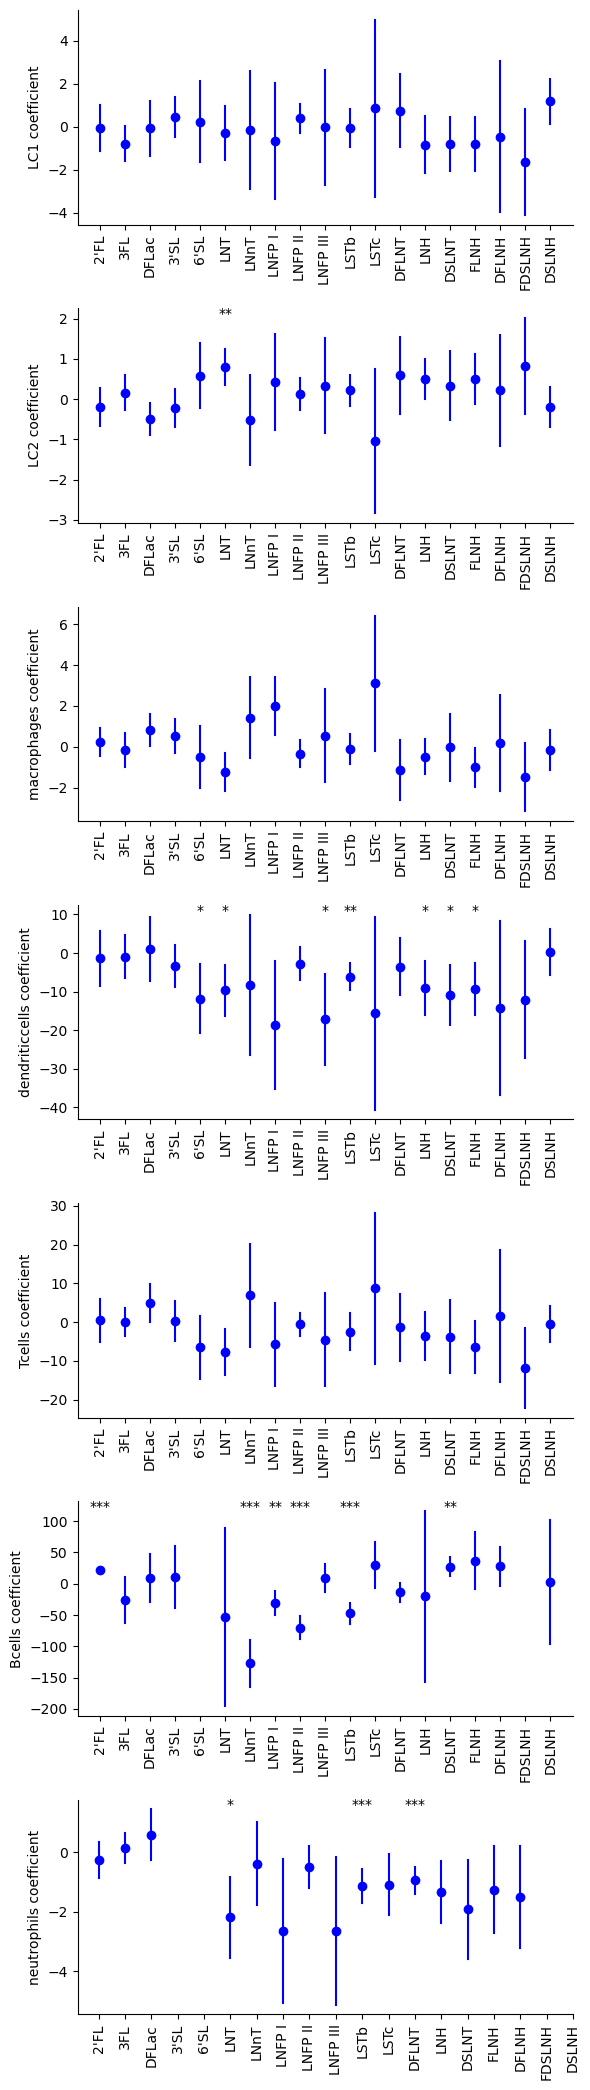

In [80]:

cts = combined_time_results_table["celltype"].unique()
plt.rcParams["figure.figsize"]=(6,3*len(cts))
fig, axs = plt.subplots(len(cts))
for ind, ct in enumerate(cts):
    plt.subplot(len(cts), 1, ind+1)
    plot_coefficients_and_int(combined_time_results_table.loc[combined_time_results_table["celltype"]==ct],ct,filter_p=False, sort_by_coef = False)
    axs[ind].spines['top'].set_visible(False)
    axs[ind].spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig("/../Figures/FigureS3 - HMO + time and celltype proportions/Fig3C_sig_HMOs_with_ctprops.pdf",bbox_inches="tight")

In [81]:
combined_time_results_table.to_csv("../Supplemental Tables/Table S3 - celltype_concentration_HMO_LLM_results.csv")